# Protein Folding - Project 00121-A3

In the following sections, we describe the work done in the scope of the project.

## Theoretical model

First of all, we define the theoretical model that we use for our work. Mainly, we used the model defined by [1]. There are three main terms that we need to consider: geometric constraints, chirality constraints and interaction energy. We define the state of the system in terms of configuration qubits $q_{c}$ and interactions qubits $q_{i}$. Configuration qubits $q_{c}$ influence geometric, chirality and interactions constraints, while $q_{i}$ mainly influence the interaction between molecules. Energy of the system is defined by a Hamiltonian $H$, which is a combination of geometric and chirality constraints, and the interaction energy. We define $H$ as follows:


$$ H = H_g(q_c) + H_{ch}(q_c) + H_{i}(q_c, q_i) $$

Where $H_g$, $H_{ch}$ and $H_i$ model, respectively, geometric constraints, chirality constraints and interaction energy.

## Prerequirements

To execute this notebook, you need to install required packages. Here are the required steps to do so:

undefined. Open a terminal (+ button in the "Terminals" tab)

undefined. cd qiskit-research

undefined. pip install .

undefined. pip install qiskit-ibm-runtime --upgrade

undefined. pip install qiskit-ibmq-provider --upgrade

undefined. pip install qoai_qiskit

## Required imports

In the following code block, we initialize all the imports that are required for the execution of the code.

In [1]:
from qiskit_research.protein_folding.interactions.random_interaction import (
    RandomInteraction,
)
from qiskit_research.protein_folding.interactions.miyazawa_jernigan_interaction import (
    MiyazawaJerniganInteraction,
)
from qiskit_research.protein_folding.peptide.peptide import Peptide
from qiskit_research.protein_folding.protein_folding_problem import (
    ProteinFoldingProblem,
)

from qiskit_research.protein_folding.penalty_parameters import PenaltyParameters

from qiskit.utils import algorithm_globals, QuantumInstance

algorithm_globals.random_seed = 23

## Main chain initialization

First of all, we need to initialize the main chain, that is the list of aminoacids forming the protein. Each aminoacid is defined by a single letter, as clarified in [2]. Following research summarised in the attached pdf files, namely "Amino_Acid_Type.pdf" and "why Dynorphin.pdf", we initialize the possible main chains as follows. 

In [2]:
possible_chains = ["APRLRFY","RPKPQQF", "CYIQNCPLG", "RPKPQQFFGLM","YFLRIPKWDNQ"]
main_chain = possible_chains[1]

NOTE: in the quantum lab, it was not possible to execute the code with chains longer than 8 aminoacids, due to RAM issues. Probably it would work with a more powerful VM. 

## Side chain initialization

Side chains are aminoacids that are attached to the residual of the main chain. We keep initialization as follows: 

In [3]:
side_chain = side_chains = [""] * len(main_chain)

## Interactions models

We mainly focus on two interactions models between aminoacids, i.e., random interactions and Miyazawa-Jernigan [3], that we initialize as follows:

In [4]:
random_interaction = RandomInteraction()
mj_interaction = MiyazawaJerniganInteraction()

## Physical Constraints

Here we define the physical constraints as penalties, to ensure that all physical constraints are respected. The terms that we use are:

- penalty_chiral: A penalty parameter used to impose the right chirality.

- penalty_back: A penalty parameter used to penalize turns along the same axis. This term is used to eliminate sequences where the same axis is chosen twice in a row.

- penalty_1: A penalty parameter used to penalize local overlap between beads within a nearest neighbor contact.

We define each constraint as follows:

In [5]:
penalty_back = 10
penalty_chiral = 10
penalty_1 = 10

penalty_terms = PenaltyParameters(penalty_chiral, penalty_back, penalty_1)

## Peptide and problem definition

Now we define the problem with all the parameters that we selected and derive our problem definition in terms of qubit operator.

In [6]:
peptide = Peptide(main_chain, side_chains)
protein_folding_problem = ProteinFoldingProblem(peptide, mj_interaction, penalty_terms)

## VQE + CVaR Expectation

Finally, we go to the solution of the problem. There are different parameters to be set in VQE to achieve the best results, namely, the type of ansatz and the optimizer. To this end, we perform a parameter study (see the notebook "hyperparameter_tuning_vqe" for details), where we evauate error of VQE for different types of of protein folding problems, considering the classic result (obtained using numpy.linalg.eigvals) as oracle to our problem. The error metric that we employ is the mean squared error, obtained using scikit-learn function mean_squared_error. Results of parameter study show that configuration achieving the minimum error is the use of RealAmplitudes as Ansatz and COBYLA as optimizer, so that is how we set our parameters.

In [7]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit import execute, Aer
from qiskit.primitives import Sampler

optimizer = COBYLA(maxiter=50)
ansatz = RealAmplitudes(reps=1)

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

vqe = SamplingVQE(
            Sampler(),
            ansatz=ansatz,
            optimizer=optimizer,
            aggregation=0.1,
            callback=store_intermediate_result,
            )
q = protein_folding_problem.qubit_op()
raw_result = vqe.compute_minimum_eigenvalue(q)

## Error Mitigation

One of the biggest challenge in quantum computing and quantum machine learning 
is the presence of noise in quantum devices. As a result, big efforts have been put into correcting
or mitigating the induced errors. In this section, we study the effect of noise on our VQE model and compare two error mitigation techniques:

1. Twirled readout error extinction:  this method uses Pauli twirling to reduce the noise introduced during the process of quantum measurement. This technique assumes no specific form of noise, which makes it very general and effective and does not require extensive computational resources. This error mitigation technique will be our benchmark, which will be compared with a more sophisticated method.

undefined. Neural error mitigation: it is a novel error mitigation method designed to improve the results of VQEs. The algorithm is based on using a neural network (with Transformer-like architecture) to perform quantum state tomography on the output of the VQE, using only a small set of measurements. This process is much more efficient than performing tomography with traditional methods. The second part of this algorithm consists of running a classical Variational Monte Carlo method with the predicted state from the neural network. Since the output of the VQE is already a good approximation of the true ground state, the VMC method should converge pretty easily. This method is based on the paper (https://arxiv.org/pdf/2105.08086.pdf) and the code has been adapted from their Github (https://github.com/1QB-Information-Technologies/NEM). 

![Neural error mitigation](/work/NEM_design.PNG)

## Error models

In this analysis we will consider two types of noise:

1. Depolarizing noise: with different error probabilities p=0.01, 0.05, 0.1 and 0.2. This noise type is the principal noise model used to describe noise in actual quantum devices.

undefined. A fake backend: We use the FakeMelbourne simulator which models the noise in an actual quantum device.

## Get noisy VQE results

In this example we run the noisy VQE with depolarizing noise with p=0.1. You can change the parameters in the function. Also, we leave the code here to submit a fake backend (or a real one), you just need to pass the backend to the function.

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.providers.fake_provider import FakeMelbourne

# In case you want to create a fake backend
backend = FakeMelbourne()

In [17]:
from Error_Mitigation.VQE_noise import *
from qoai_qiskit import *
provider = load_account()

raw_result_noise, counts_noise, values_noise, params_noise, ansatz, vqe, noise_model, sampler, qubit_op = run_VQE(main_chain=main_chain, side_chains=None, 
                            interaction='MJ',penalty_back=10,penalty_chiral=10,penalty_1=10,
                            #fake_backend = backend,  # Uncomment this line to use the fake backend
                             noise_model='depolarizing',p=0.01,
                            resilience_level=1, aggregation=0.1)

configrc.store_credentials:WARNING:2023-05-19 09:08:51,525: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-05-19 09:08:51,674: Credentials are already in use. The existing account in the session will be replaced.
successfully connected to IBMQ runtime!


In [18]:
print(raw_result_noise)
raw_result_noise

SamplingMinimumEigensolverResult:
	Eigenvalue: -1.331999999999653
	Best measurement
: {'state': 326, 'bitstring': '101000110', 'value': (-1.3319999999996526+0j), 'probability': 0.020442392999909537}



## Get brute-force ground state

For comparison, we test all the possible bit-strings and sort them according to the energy of the system. This will provide the true ground states and the first excited states.

In [12]:
idx, energies = get_ground_state(qubit_op)
print('Sorted bit-srings (in decimal form) ',idx[:10], ' with energies ', energies[:10])

## Get the measurements data

From the best VQE parameters run 3000 simulations and get the samples in each case (i.e in shot 1 we get '000110010', in shot 2 we get '111000101', etc.) We perform measurements in multiple basis, where each qubit is measured in the Z basis and 0,1 or 2 qubits are measured in the X basis (i.e 'ZZZZZZZZZ', 'XZZZZZZZZ', 'XXZZZZZZZ',...)

In [19]:
measurement_data, bases, dists = get_measurement_dict(ansatz, params_noise, sampler, num_samples_per_basis=3000)

Which measurements were taken dict_keys(['ZZZZZZZZZ', 'XZZZZZZZZ', 'ZXZZZZZZZ', 'ZZXZZZZZZ', 'ZZZXZZZZZ', 'ZZZZXZZZZ', 'ZZZZZXZZZ', 'ZZZZZZXZZ', 'ZZZZZZZXZ', 'ZZZZZZZZX', 'XXZZZZZZZ', 'XZXZZZZZZ', 'XZZXZZZZZ', 'XZZZXZZZZ', 'XZZZZXZZZ', 'XZZZZZXZZ', 'XZZZZZZXZ', 'XZZZZZZZX', 'ZXXZZZZZZ', 'ZXZXZZZZZ', 'ZXZZXZZZZ', 'ZXZZZXZZZ', 'ZXZZZZXZZ', 'ZXZZZZZXZ', 'ZXZZZZZZX', 'ZZXXZZZZZ', 'ZZXZXZZZZ', 'ZZXZZXZZZ', 'ZZXZZZXZZ', 'ZZXZZZZXZ', 'ZZXZZZZZX', 'ZZZXXZZZZ', 'ZZZXZXZZZ', 'ZZZXZZXZZ', 'ZZZXZZZXZ', 'ZZZXZZZZX', 'ZZZZXXZZZ', 'ZZZZXZXZZ', 'ZZZZXZZXZ', 'ZZZZXZZZX', 'ZZZZZXXZZ', 'ZZZZZXZXZ', 'ZZZZZXZZX', 'ZZZZZZXXZ', 'ZZZZZZXZX', 'ZZZZZZZXX'])
bases =  [[2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2], [2, 0, 2, 2, 2, 2, 2, 2, 2], [2, 2, 0, 2, 2, 2, 2, 2, 2], [2, 2, 2, 0, 2, 2, 2, 2, 2], [2, 2, 2, 2, 0, 2, 2, 2, 2], [2, 2, 2, 2, 2, 0, 2, 2, 2], [2, 2, 2, 2, 2, 2, 0, 2, 2], [2, 2, 2, 2, 2, 2, 2, 0, 2], [2, 2, 2, 2, 2, 2, 2, 2, 0], [0, 0, 2, 2, 2, 2, 2, 2, 2], [0, 2, 0, 2, 2, 2, 2, 2, 2], [0

## Get neural quantum state network

Generate the transformer neural network which produces quantum state tomography from a small set of measurements.

In [20]:
import Error_Mitigation.nqs_models as nqs_models
from Error_Mitigation.trainers import NeuralErrorMitigationTrainer
import Error_Mitigation.physics_models as physics_models
import torch
print ("Is GPU cuda device available = ", torch.cuda.is_available())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print ("Module using ", device, "device" )
cpu = torch.device('cpu')

# Physics model
mol = physics_models.ProteinFoldingModel(qubit_op)
nqs_transformer = nqs_models.TransformerWF( num_sites = ansatz.num_qubits,
                                            num_layers=2,
                                            internal_dimension=8,
                                            num_heads=4,
                                            dropout=0.0).to(device)

Is GPU cuda device available =  False
Module using  cpu device


## Train the neural error mitigation algorithm

the algorithm has two steps: the neural quantum state, which learns the quantum statevector given the set of measurements, and the Variational Monte Carlo algorithm, which refines the solution. 

In [21]:
epsilon = 0.0
vmc_iters = 1000
constant_reg_schedule = lambda iter : epsilon if iter < vmc_iters//2 else 0.0
nemtrainer = NeuralErrorMitigationTrainer(nqs_model=nqs_transformer,
                                            measurement_data=measurement_data,
                                            physics_model=mol,
                                            #NQST Parameters
                                            nqst_max_epochs=10,
                                            nqst_lr=1e-2,
                                            nqst_batch_size=256,
                                            #VMC Parameters
                                            vmc_lr=1e-2,
                                            vmc_iterations=vmc_iters,
                                            vmc_batch_size=2048,
                                            vmc_epsilon=constant_reg_schedule,
                                            vmc_regularization_type='L1',
                                            logdir=None
                                            )

nemtrainer.train()

No log directory given for the tensorboard writer
Will not log results
Performing nerual quantum state tomogrpahy on dataset
Epoch:0. Val KL:4.32538657810377. Infidelity to Groundstate:0.9978315234184265.
Epoch:1. Val KL:4.32618036021357. Infidelity to Groundstate:0.997717022895813.
Epoch:2. Val KL:4.325666114696558. Infidelity to Groundstate:0.9974735379219055.
Epoch:3. Val KL:4.330978751804517. Infidelity to Groundstate:0.9968947172164917.
Epoch:4. Val KL:4.323180015674536. Infidelity to Groundstate:0.9978572726249695.
Epoch:5. Val KL:4.319688581383747. Infidelity to Groundstate:0.997621476650238.
Epoch:6. Val KL:4.324618284805961. Infidelity to Groundstate:0.9981763362884521.
Epoch:7. Val KL:4.317628560826399. Infidelity to Groundstate:0.9976229071617126.
Epoch:8. Val KL:4.324931963492131. Infidelity to Groundstate:0.9975262880325317.
Epoch:9. Val KL:4.327716486834098. Infidelity to Groundstate:0.9976649880409241.
NQST Results:
    Energy =  tensor(1175.7777, grad_fn=<SumBackward1>)

## Visualize the error mitigation results

Notice that this analysis is done with the APRLRFY chain, which was the example of the original protein folding paper.

Ground state before error mitigation:  326  with probability  0.020442392999909537
Ground state after error mitigation:  326  with probability  0.99999785


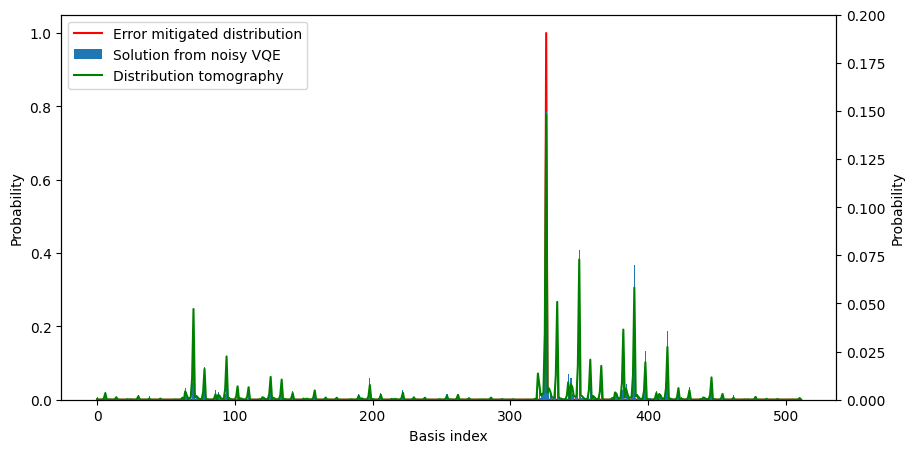

In [22]:
import numpy as np
import matplotlib.pyplot as plt
final_state = nemtrainer.final_errmit_state.full_state().detach().numpy() 
distribution = (final_state*final_state.conj()).real

tomography_state = nemtrainer.final_nqst_state.full_state().detach().numpy() 
distribution_tomography = (tomography_state*tomography_state.conj()).real
print('Ground state before error mitigation: ',raw_result_noise.best_measurement['state'], ' with probability ',  raw_result_noise.best_measurement['probability'])

print('Ground state after error mitigation: ', np.arange(distribution.shape[0])[distribution>0.1][0], ' with probability ', distribution[distribution>0.1][0])

fig, (ax1) = plt.subplots(1,1,figsize=(10,5))
ln1 = ax1.plot(range(distribution.shape[0]), distribution, color='red', label="Error mitigated distribution")
ax1.set_ylim(0,1.05)
ax1.set_xlabel("Basis index")
ax1.set_ylabel("Probability")
ax2 = ax1.twinx()
ln2 = ax2.bar(list(raw_result_noise.eigenstate.keys()), list(raw_result_noise.eigenstate.values()), label="Solution from noisy VQE")
ax2.set_ylim(0,0.2)
ax2.set_ylabel("Probability")
ln3 = ax2.plot(range(distribution_tomography.shape[0]), distribution_tomography, color='green')
plt.legend([ln1[0], ln2, ln3[0]], ['Error mitigated distribution', 'Solution from noisy VQE',
            'Distribution tomography'], loc='upper left')

## Save the results

In [31]:
import pickle
# Uncomment to save the results
outfileprefix = 'Error_Mitigation/results/'+main_chain+'/'
with open(outfileprefix + 'error_mitigated_state_depolarizing01.npy', 'wb') as f:
    np.save(f,final_state)

with open(outfileprefix + 'vqe_state_depolarizing01.npy', 'wb') as f:
    pickle.dump(raw_result_noise,f)

## Load all the results

In [34]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

outfileprefix = 'Error_Mitigation/results/APRLRFY/'
with open(outfileprefix + 'error_mitigated_state_depolarizing01.npy', 'rb') as f:
    state_mitig_01 = np.load(f)
with open(outfileprefix + 'vqe_state_depolarizing01.npy', 'rb') as f:
    state_noise_01 = pickle.load(f)

with open(outfileprefix + 'error_mitigated_state_depolarizing05.npy', 'rb') as f:
    state_mitig_05 = np.load(f)
with open(outfileprefix + 'vqe_state_depolarizing05.npy', 'rb') as f:
    state_noise_05 = pickle.load(f)

with open(outfileprefix + 'error_mitigated_state_depolarizing1.npy', 'rb') as f:
    state_mitig_1 = np.load(f)
with open(outfileprefix + 'vqe_state_depolarizing1.npy', 'rb') as f:
    state_noise_1 = pickle.load(f)

with open(outfileprefix + 'error_mitigated_state_depolarizing2.npy', 'rb') as f:
    state_mitig_2 = np.load(f)
with open(outfileprefix + 'vqe_state_depolarizing2.npy', 'rb') as f:
    state_noise_2 = pickle.load(f)

with open(outfileprefix + 'error_mitigated_state_fake.npy', 'rb') as f:
    state_mitig_fake = np.load(f)
with open(outfileprefix + 'vqe_state_fake.npy', 'rb') as f:
    state_noise_fake = pickle.load(f)

states_mitig_list = [state_mitig_01,state_mitig_05,state_mitig_1,state_mitig_2, state_mitig_fake]
states_noise_list = [state_noise_01,state_noise_05,state_noise_1,state_noise_2,state_noise_fake]
titles = ['Depolarizing p=0.01', 'Depolarizing p=0.05', 'Depolarizing p=0.1', 'Depolarizing p=0.2',
            'Fake backend']

# Neural error mitigation results

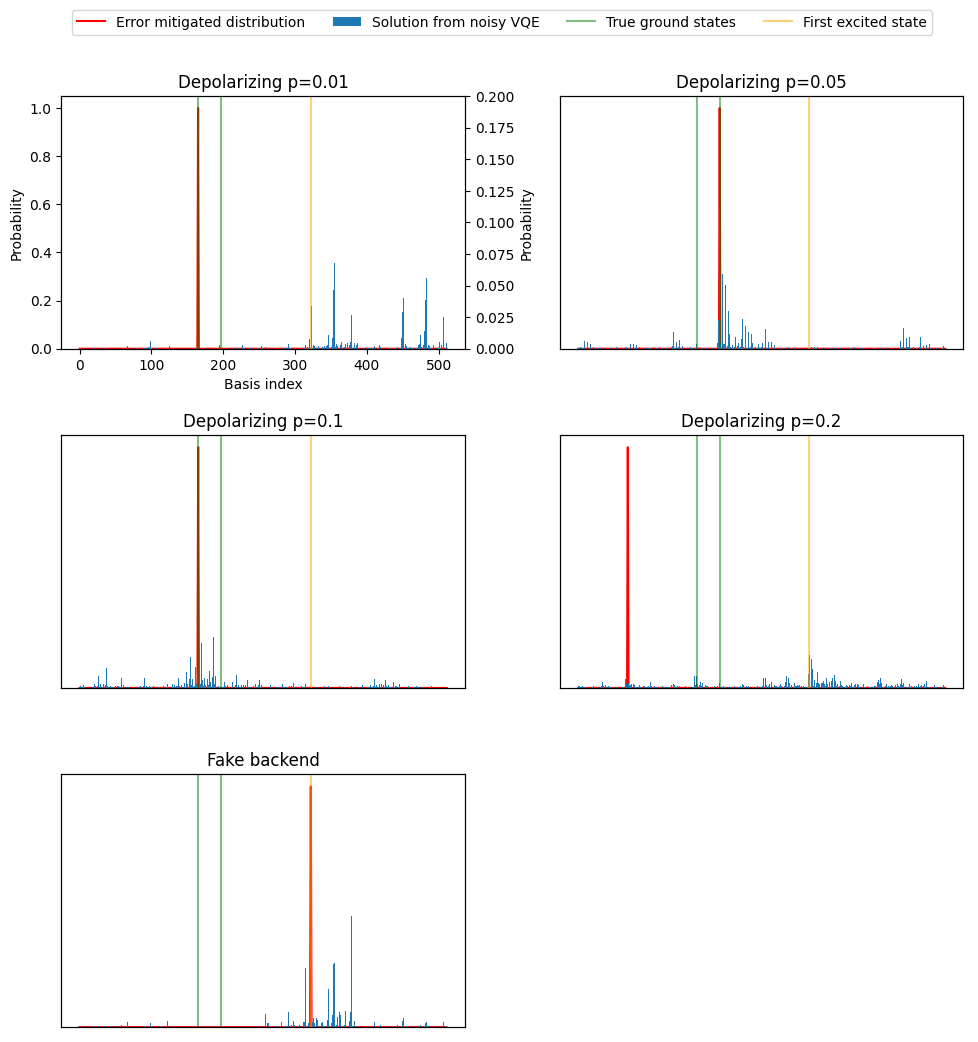

In [35]:
row,col=3,2
fig, ax = plt.subplots(row,col,figsize=(10,10))
for k in range(len(states_mitig_list)):
    i = k//col
    j = k%col
    mitig = states_mitig_list[k]
    mitig = (mitig*mitig.conj()).real
    noise = states_noise_list[k]
    
    ln1 = ax[i][j].plot(range(mitig.shape[0]), mitig, color='red')
    ax[i][j].set_ylim(0,1.05)
    ax2 = ax[i][j].twinx()
    ln3 = ax2.axvline(165, color='green', alpha=0.5)
    ax2.axvline(197, color='green', alpha=0.5)
    ln4 = ax2.axvline(322, color='orange', alpha=0.5)
    ln2 = ax2.bar(list(noise.eigenstate.keys()), list(noise.eigenstate.values()))
    ax2.set_ylim(0,0.2)
    ax2.set_title(titles[k])
    
    if k==0:
        ax2.set_ylabel("Probability")
        fig.legend([ln1[0], ln2, ln3, ln4], ['Error mitigated distribution', 'Solution from noisy VQE',
        'True ground states', 'First excited state'], bbox_to_anchor=(0.95,1.05), ncol=4)
    else:
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])
ax[0][0].set_xlabel("Basis index")
ax[0][0].set_ylabel("Probability")
ax[2][1].remove()
fig.tight_layout(pad=1.5)



# t-REX results

In [36]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('Error_Mitigation/results/APRLRFY/vqe_state_trex_01.npy', 'rb') as f:
    state_mitig_01 = np.load(f, allow_pickle=True)
with open('Error_Mitigation/results/APRLRFY/vqe_state_trex_05.npy', 'rb') as f:
    state_mitig_05 = np.load(f, allow_pickle=True)
with open('Error_Mitigation/results/APRLRFY/vqe_state_trex_1.npy', 'rb') as f:
    state_mitig_1 = np.load(f, allow_pickle=True)
with open('Error_Mitigation/results/APRLRFY/vqe_state_trex_2.npy', 'rb') as f:
    state_mitig_2 = np.load(f, allow_pickle=True)
with open('Error_Mitigation/results/APRLRFY/vqe_state_trex_fake.npy', 'rb') as f:
    state_mitig_fake = np.load(f, allow_pickle=True)

states_mitig_list = [state_mitig_01,state_mitig_05,state_mitig_1,state_mitig_2, state_mitig_fake]
states_noise_list = [state_noise_01,state_noise_05,state_noise_1,state_noise_2,state_noise_fake]
titles = ['Depolarizing p=0.01', 'Depolarizing p=0.05', 'Depolarizing p=0.1', 'Depolarizing p=0.2',
            'Fake backend']

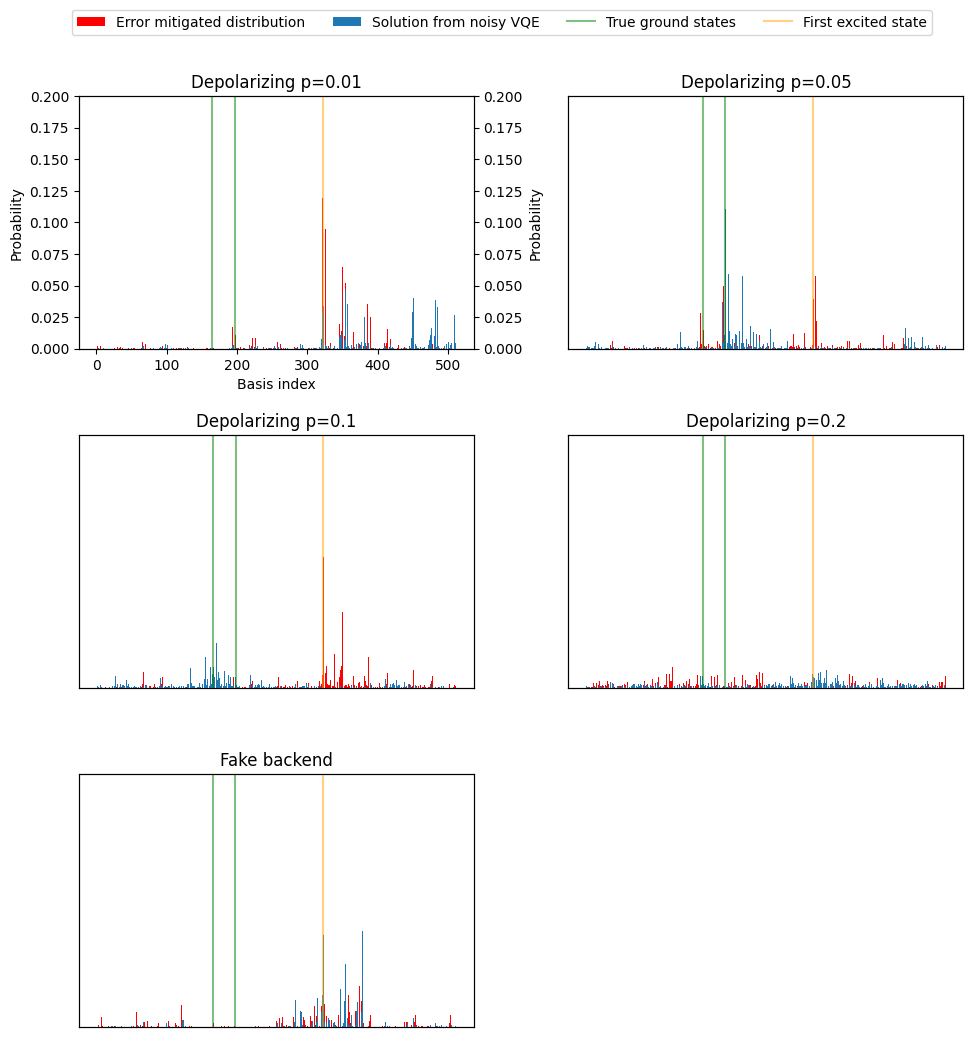

In [37]:
row,col=3,2
fig, ax = plt.subplots(row,col,figsize=(10,10))
for k in range(len(states_mitig_list)):
    i = k//col
    j = k%col
    mitig = states_mitig_list[k]
    noise = states_noise_list[k]
    ln1 = ax[i][j].bar(list(mitig.eigenstate.keys()), list(mitig.eigenstate.values()), color='red')
    ax[i][j].set_ylim(0,0.2)
    ax2 = ax[i][j].twinx()
    ln3 = ax2.axvline(165, color='green', alpha=0.5)
    ax2.axvline(197, color='green', alpha=0.5)
    ln4 = ax2.axvline(322, color='orange', alpha=0.5)
    ln2 = ax2.bar(list(noise.eigenstate.keys()), list(noise.eigenstate.values()))
    ax2.set_ylim(0,0.2)
    ax2.set_title(titles[k])
    
    if k==0:
        ax2.set_ylabel("Probability")
        fig.legend([ln1, ln2, ln3, ln4], ['Error mitigated distribution', 'Solution from noisy VQE',
        'True ground states', 'First excited state'], bbox_to_anchor=(0.95,1.05), ncol=4)
    else:
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])
ax[0][0].set_xlabel("Basis index")
ax[0][0].set_ylabel("Probability")
ax[2][1].remove()
fig.tight_layout(pad=1.5)


Let us comment the resuls of the error mitigation techniques:

### Neural error mitigation

1. The neural error mitigation method is in general very effective at finding the true ground state of the Hamiltonian. For the depolarizing noise, for probabilities p<0.02, the NEM method correctly produces the ground state.  Moreover, while the amplitude of the ground state obtained with the VQE is very small, the NEM method returns the ground state with probability almost equal to 1. This proves that the NEM method is very suitable for this task.

2. In the case when we use a fake backend, the NEM returns the first excited state, instead of the true ground state. It must be said, though, that the amplitude of the VQE state has almost 0 amplitude on the ground state, which must be the reason why the VMC only finds states that are orthogonal to this ground state. 

undefined. The main limitation of this NEM method is the scaling with the number of qubits. The quantum state tomography process uses a neural network to fully reconstruct the quantum statevector of the VQE. Even though the neural network approach significantly reduces the complexity of conventional state tomography methods, the output of the network is still a complex-valued vector which scales exponentially with the dimension of the system. For this reason, this method will not be efficient for large number of qubits.

### t-REX

The t-REX algorithm is not successful in finding the true ground state of the Hamiltonian. We can see that for small error probabilities, the mitigated result has a high amplitude around the first excited state, while the amplitude of the true ground state is almost erased. When the error probability increases, this error mitigation technique almost erases the amplitude of all quantum states. As a result, we conclude that this error mitigation method is not appropriate for this task, and it should be used only on systems where the error is weaker and easier to mitigate.

## Visualization

Finally, we visualize the refined output of our solution as follows:

The bitstring representing the shape of the protein during optimization is:  101100011
The expanded expression is: 1______0_____________________________________________________________________________________________________________________________110001_1____
The folded protein's main sequence of turns is: [1, 0, 3, 2, 0, 3]
and the side turn sequences are: [None, None, None, None, None, None, None]
[['R' '0.0' '0.0' '0.0']
 ['P' '0.5773502691896258' '0.5773502691896258' '-0.5773502691896258']
 ['K' '1.1547005383792517' '0.0' '-1.1547005383792517']
 ['P' '1.7320508075688776' '-0.5773502691896258' '-0.5773502691896258']
 ['Q' '2.3094010767585034' '0.0' '0.0']
 ['Q' '1.7320508075688776' '0.5773502691896258' '0.5773502691896258']
 ['F' '1.154700538379252' '1.1547005383792517' '0.0']]


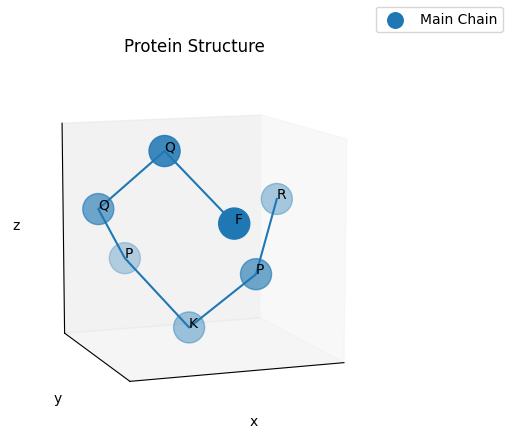

In [38]:
result = protein_folding_problem.interpret(raw_result=raw_result)
print(
    "The bitstring representing the shape of the protein during optimization is: ",
    result.turn_sequence,
)
print("The expanded expression is:", result.get_result_binary_vector())
print(
    f"The folded protein's main sequence of turns is: {result.protein_shape_decoder.main_turns}"
)
print(f"and the side turn sequences are: {result.protein_shape_decoder.side_turns}")
print(result.protein_shape_file_gen.get_xyz_data())
fig = result.get_figure(title="Protein Structure", ticks=False, grid=True)
fig.get_axes()[0].view_init(10, 70)

## References

[1] A.Robert, P.Barkoutsos, S.Woerner and I.Tavernelli, Resource-efficient quantum algorithm for protein folding, NPJ Quantum Information, 2021, https://doi.org/10.1038/s41534-021-00368-4 

[2] IUPAC–IUB Commission on Biochemical Nomenclature (1972). "A one-letter notation for aminoacid sequences". Pure and Applied Chemistry. 31 (4): 641–645. doi:10.1351/pac197231040639. PMID 5080161. 

[3] S. Miyazawa and R. L.Jernigan, Residue – Residue Potentials with a Favorable Contact Pair Term and an Unfavorable High Packing Density Term for Simulation and Threading, J. Mol. Biol.256, 623–644, 1996, Table 3, https://doi.org/10.1006/jmbi.1996.0114 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ddc54cc5-de90-4346-ada1-4ff24feba045' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>